In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
import random
from sklearn.metrics import mean_squared_error
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel, ExpSineSquared, RationalQuadratic

## Data Process and Split

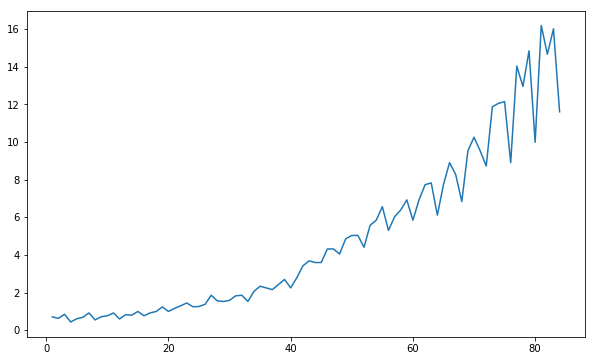

In [2]:
jj = pd.read_csv('/Users/luyin/Downloads/timeseries2018-master 2/data/jj.csv')
df = jj.rename(index=str, columns={"Unnamed: 0": "Quarter index", "x": "Quarterly Earning"})
plt.figure(figsize=(10,6))
plt.plot(df['Quarter index'], df['Quarterly Earning'])

In [3]:
# df['log_earning'] = np.log(df['Quarterly Earning'])

In [4]:
df_train = df[:]
df_train.shape[0] # all training data

84

In [5]:
x_train = df_train['Quarter index']
y_train = df_train['Quarterly Earning']

In [6]:
df_test = df[40:64]
df_test.shape[0] # 1970 - 1975 test sets
x_test = df_test['Quarter index']
y_test = df_test['Quarterly Earning']

In [7]:
random.seed(5)
df_sample_t = df_test.sample(frac=0.5, replace=False, random_state = 5) #sampling 50% data from original dataset
x_sample_t = df_sample_t['Quarter index']
y_sample_t = df_sample_t['Quarterly Earning'] #traing sets 
x_sample_t[0]

61

In [8]:
def plot_gp(x_pred, y_pred, sigmas, x_train, y_train, kernel, true_y=None, samples=None):
    
    plt.figure(figsize=(10,6))
    plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
             np.concatenate([y_pred.reshape(y_pred.shape[0]) - 1.9600 * sigmas,
                        (y_pred.reshape(y_pred.shape[0])+ 1.9600 * sigmas)[::-1]]),
         alpha=.2, fc='g', ec='None') #95% confidence interval
    plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0, 
                 ecolor=(0.9, 0.9, 0.9), fmt = "r--", 
                 label="pred mean")
    plt.plot(x_train, y_train, "k.", label="training set")
    if true_y is not None:
        plt.plot(x_pred, true_y, "b-", label="truth function")
    if samples is not None:
        plt.plot(all_x.reshape(-1, 1), samples)
    plt.title("GPregression with {0}".format(kernel))
    plt.legend()

## Radial-basis function (RBF) kernel

In [9]:
kernel_1= RBF()
gp = gaussian_process.GaussianProcessRegressor(kernel = kernel_1)
gp.fit(x_sample_t.values.reshape(-1,1), y_sample_t.values.reshape(-1,1))

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1), n_restarts_optimizer=0,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

/Users/luyin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


RMSE: 1.2357881187309123
Log-marginal-likelihood: -115.589


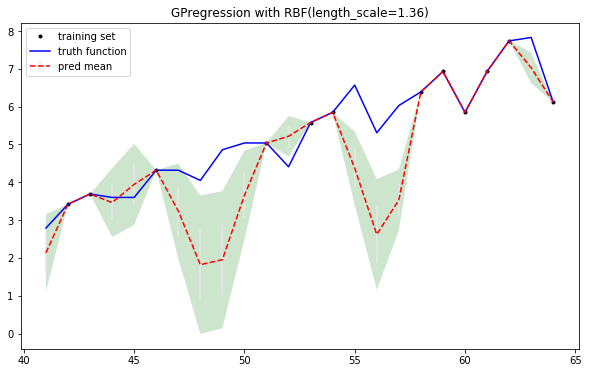

In [10]:
mus, sigmas = gp.predict(x_test.reshape(-1,1), return_std=True)
plot_gp(x_test, mus, sigmas, x_sample_t.values, y_sample_t.values, gp.kernel_, true_y = y_test)
print("RMSE: {0}".format(np.sqrt(mean_squared_error(mus, y_test))))
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

The RBF kernel works fine on catching the increasing trend of the quarterly earings. However, RBF performs just OK to capture the periodical patterns.

## Exp-Sine-Squared kernel

In [11]:
kernel_2= ExpSineSquared()
gp_2 = gaussian_process.GaussianProcessRegressor(kernel = kernel_2)
gp_2.fit(x_sample_t.values.reshape(-1,1), y_sample_t.values.reshape(-1,1))

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=ExpSineSquared(length_scale=1, periodicity=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

/Users/luyin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


RMSE: 3.5722839332841394
Log-marginal-likelihood: -212.628


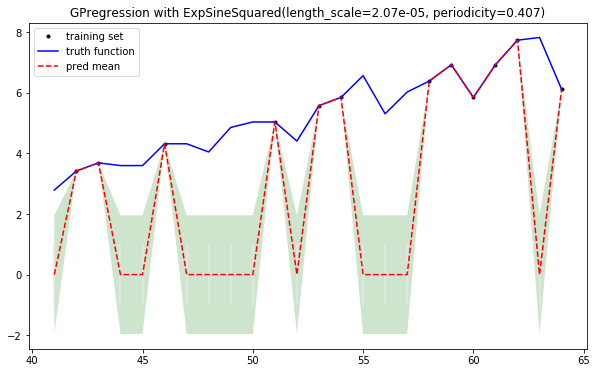

In [12]:
mus_2, sigmas_2 = gp_2.predict(x_test.reshape(-1,1), return_std=True)
plot_gp(x_test, mus_2, sigmas_2, x_sample_t.values, y_sample_t.values, gp_2.kernel_, true_y = y_test)
print("RMSE: {0}".format(np.sqrt(mean_squared_error(mus_2, y_test))))
print("Log-marginal-likelihood: %.3f"
      % gp_2.log_marginal_likelihood(gp_2.kernel_.theta))

In [13]:
gp_2.kernel_

ExpSineSquared(length_scale=2.07e-05, periodicity=0.407)

Compared with RBF, Exp-Sine-Squared kernel can (occationally) catch of the periodic structures but poor in catch the increasing mean. However, Exp-Sine-Squared's performance depends on the sampling data points. 

## Rational Quadratic kernel

In [14]:
kernel_3 = RationalQuadratic()
gp_3 = gaussian_process.GaussianProcessRegressor(kernel = kernel_3)
gp_3.fit(x_sample_t.values.reshape(-1,1),y_sample_t.values.reshape(-1,1))

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RationalQuadratic(alpha=1, length_scale=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

/Users/luyin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


RMSE: 0.4303968499981673
Log-marginal-likelihood: -40.517


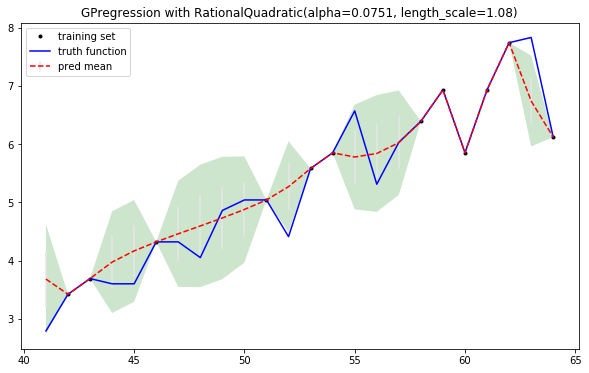

In [15]:
mus_3, sigmas_3 = gp_3.predict(x_test.reshape(-1,1), return_std=True)
plot_gp(x_test, mus_3, sigmas_3, x_sample_t.values, y_sample_t.values, gp_3.kernel_, true_y = y_test)
print("RMSE: {0}".format(np.sqrt(mean_squared_error(mus_3, y_test))))
print("Log-marginal-likelihood: %.3f"
      % gp_3.log_marginal_likelihood(gp_3.kernel_.theta))

Rational Quadratic kernel can be seen as a scale mixture of RBF kernels with different characteristic length-scales. In this case Rational Quadratic kernel behaves a lot more better than the other 2 kernels. But with a different sampling of the data, things may be different. 

## Kernel combination without noise

In [16]:
# kernel_mix = RBF() + RationalQuadratic() + ExpSineSquared() # + WhiteKernel() + ConstantKernel()
k1 = RBF()  # long term smooth rising trend
k2 = ExpSineSquared()* RBF() # seasonal component
k3 = RationalQuadratic()
k4 = WhiteKernel()  # noise terms
kernel_mix = k1 + k2 + k3

gp_4 = gaussian_process.GaussianProcessRegressor(kernel = kernel_mix, n_restarts_optimizer=0, normalize_y=False, optimizer='fmin_l_bfgs_b')
gp_4.fit(x_sample_t.values.reshape(-1,1), y_sample_t.values.reshape(-1,1))

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1) + ExpSineSquared(length_scale=1, periodicity=1) * RBF(length_scale=1) + RationalQuadratic(alpha=1, length_scale=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [17]:
gp_4.kernel_

RBF(length_scale=16.5) + ExpSineSquared(length_scale=2.51, periodicity=0.589) * RBF(length_scale=13.7) + RationalQuadratic(alpha=0.015, length_scale=0.959)

/Users/luyin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


RMSE = 0.5103967409112296
Log-marginal-likelihood: -18.027


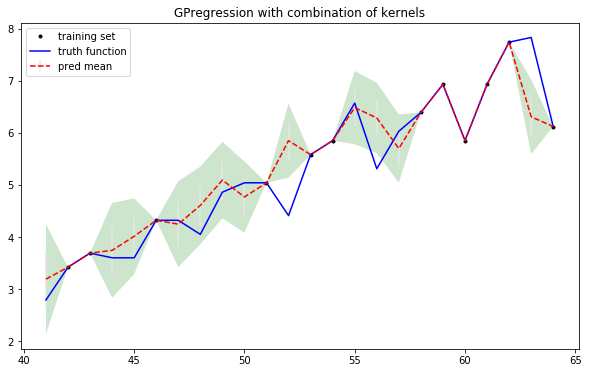

In [18]:
mus_4, sigmas_4 = gp_4.predict(x_test.reshape(-1,1), return_std=True)
plot_gp(x_test, mus_4, sigmas_4, x_sample_t.values, y_sample_t.values, gp_4.kernel_, true_y = y_test)
plt.title("GPregression with combination of kernels")
print("RMSE = {0}".format(np.sqrt(mean_squared_error(mus_4, y_test))))
print("Log-marginal-likelihood: %.3f"
      % gp_4.log_marginal_likelihood(gp_4.kernel_.theta))

## Kernel combination with noise

In [19]:
# kernel_mix = RBF() + RationalQuadratic() + ExpSineSquared() # + WhiteKernel() + ConstantKernel()
k1 = RBF()  # long term smooth rising trend
k2 = ExpSineSquared() * RBF()  # seasonal component
k3 = RationalQuadratic()
k4 = WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)) + RBF() # noise terms
kernel_mix = k1 + k2 + k3 + k4

In [20]:
gp_5 = gaussian_process.GaussianProcessRegressor(kernel = kernel_mix, n_restarts_optimizer=0, normalize_y=False, optimizer='fmin_l_bfgs_b')
gp_5.fit(x_sample_t.values.reshape(-1,1), y_sample_t.values.reshape(-1,1))

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1) + ExpSineSquared(length_scale=1, periodicity=1) * RBF(length_scale=1) + RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1) + RBF(length_scale=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [21]:
gp_5.kernel_

RBF(length_scale=20.4) + ExpSineSquared(length_scale=0.849, periodicity=1) * RBF(length_scale=20.4) + RationalQuadratic(alpha=1e+05, length_scale=20.4) + WhiteKernel(noise_level=0.251) + RBF(length_scale=20.4)

/Users/luyin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


RMSE: 0.5383455804125278
Log-marginal-likelihood: -17.534


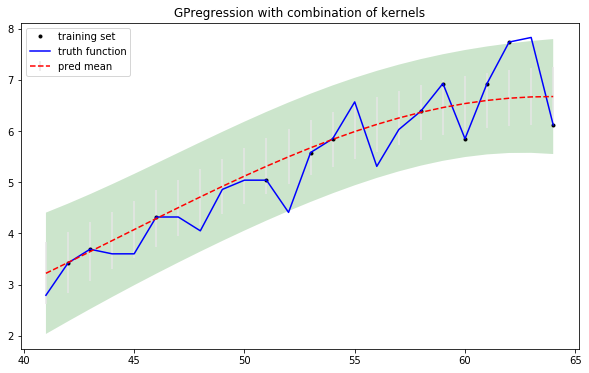

In [22]:
mus_5, sigmas_5 = gp_5.predict(x_test.reshape(-1,1), return_std=True)
plot_gp(x_test, mus_5, sigmas_5, x_sample_t.values, y_sample_t.values, gp_5.kernel_, true_y = y_test)
plt.title("GPregression with combination of kernels")
print("RMSE: {0}".format(np.sqrt(mean_squared_error(mus_5, y_test))))
print("Log-marginal-likelihood: %.3f"
      % gp_5.log_marginal_likelihood(gp_5.kernel_.theta))

The combination of kernels with white kernel works better than the no noise version in terms of the theta. In addtion, the function tends to be smoother than previosu one. However, given the higher LML, the RMSE is not necessarily improved. Also, the confidence interval is changed after introducing the noise. Looks like the noise level is a little bit high because some of the real points is missing on the function.

Therefore, the noise level can also be studied in terms of the change of LML. Change the initial noise level from the white kernel to 1e-5

In [23]:
k1 = RBF()  # long term smooth rising trend
k2 = ExpSineSquared() * RBF()  # seasonal component
k3 = RationalQuadratic()
k4 = WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-10, 1e+1)) + RBF() # noise terms
kernel_mix = k1 + k2 + k3 + k4

In [24]:
gp_6 = gaussian_process.GaussianProcessRegressor(kernel = kernel_mix, n_restarts_optimizer=0, normalize_y=False, optimizer='fmin_l_bfgs_b')
gp_6.fit(x_sample_t.values.reshape(-1,1), y_sample_t.values.reshape(-1,1))

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1) + ExpSineSquared(length_scale=1, periodicity=1) * RBF(length_scale=1) + RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=0.0001) + RBF(length_scale=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

/Users/luyin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


RMSE: 0.5027491700756263
Log-marginal-likelihood: -16.951


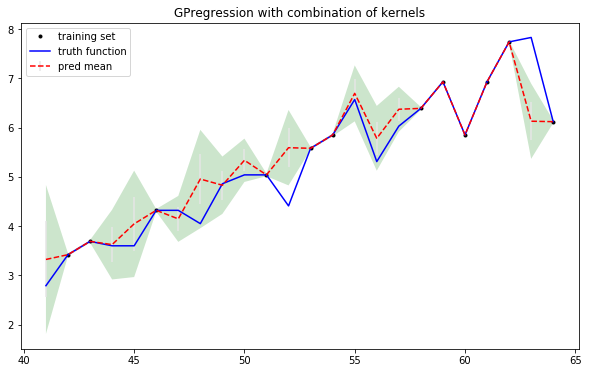

In [25]:
mus_6, sigmas_6 = gp_6.predict(x_test.reshape(-1,1), return_std=True)
plot_gp(x_test, mus_6, sigmas_6, x_sample_t.values, y_sample_t.values, gp_6.kernel_, true_y = y_test)
plt.title("GPregression with combination of kernels")
print("RMSE: {0}".format(np.sqrt(mean_squared_error(mus_6, y_test))))
print("Log-marginal-likelihood: %.3f"
      % gp_5.log_marginal_likelihood(gp_6.kernel_.theta))

In [26]:
gp_6.kernel_

RBF(length_scale=17.9) + ExpSineSquared(length_scale=1.12, periodicity=0.781) * RBF(length_scale=12.8) + RationalQuadratic(alpha=1e-05, length_scale=106) + WhiteKernel(noise_level=9.63e-05) + RBF(length_scale=17.9)

With different initial kernel, the smaller noise level also has a smaller length_scale. RMSE and LML are both improved. The predict function seems to catch the data points and at a same with a certain level of smooth. 

## Prediction after 1980 with noise

In [27]:
x_test_all = np.arange(1,96)

In [28]:
gp_new = gaussian_process.GaussianProcessRegressor(kernel = gp_5.kernel_)
gp_new.fit(x_train.values.reshape(-1,1), y_train.values.reshape(-1,1))

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=20.4) + ExpSineSquared(length_scale=0.849, periodicity=1) * RBF(length_scale=20.4) + RationalQuadratic(alpha=1e+05, length_scale=20.4) + WhiteKernel(noise_level=0.251) + RBF(length_scale=20.4),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [29]:
mus_new, sigmas_new = gp_new.predict(x_test_all.reshape(-1,1), return_std=True)

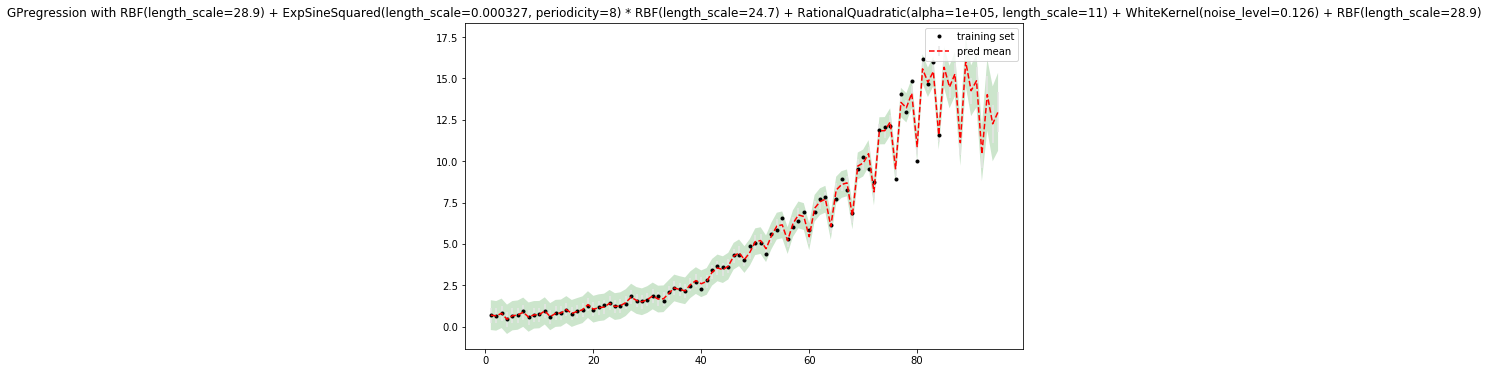

In [30]:
plot_gp(x_test_all, mus_new, sigmas_new, x_train.values, y_train.values, gp_new.kernel_)

In [31]:
gp_new.kernel_

RBF(length_scale=28.9) + ExpSineSquared(length_scale=0.000327, periodicity=8) * RBF(length_scale=24.7) + RationalQuadratic(alpha=1e+05, length_scale=11) + WhiteKernel(noise_level=0.126) + RBF(length_scale=28.9)

This is the gaussian with the initial kernel from "gp_5.kernel_" with higher level of noise. The prediction is fine with the first several points but as the time goes, there is a higher uncertainty with the predictions. Seems like the model catch some of the seasonal patterns especially for the last several years. 

### Prediction with lower noise level

In [32]:
gp_new_1 = gaussian_process.GaussianProcessRegressor(kernel = gp_6.kernel_)
gp_new_1.fit(x_train.values.reshape(-1,1), y_train.values.reshape(-1,1))

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=17.9) + ExpSineSquared(length_scale=1.12, periodicity=0.781) * RBF(length_scale=12.8) + RationalQuadratic(alpha=1e-05, length_scale=106) + WhiteKernel(noise_level=9.63e-05) + RBF(length_scale=17.9),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [33]:
mus_new_1, sigmas_new_1 = gp_new_1.predict(x_test_all.reshape(-1,1), return_std=True)

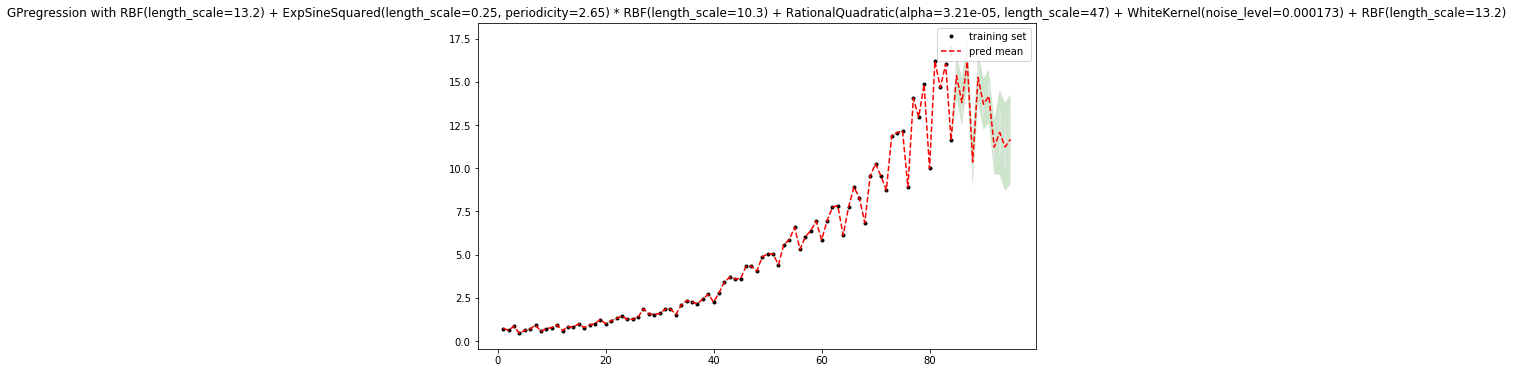

In [34]:
plot_gp(x_test_all, mus_new_1, sigmas_new_1, x_train.values, y_train.values, gp_new_1.kernel_)

This is the gaussian with the kernel of "gp_6.kernel_" with lower level of noise. 

In [35]:
gp_new_1.kernel_

RBF(length_scale=13.2) + ExpSineSquared(length_scale=0.25, periodicity=2.65) * RBF(length_scale=10.3) + RationalQuadratic(alpha=3.21e-05, length_scale=47) + WhiteKernel(noise_level=0.000173) + RBF(length_scale=13.2)